In [1]:
import numpy as np
import pandas as pd
import sys

class Photonic:
	def __init__(self, config=None):
		self.c = 2.99792458e8  # [m/s] Speed of light
		self.hc = 1.987820871E-025  # [J * m / photon] Energy of photon with wavelength m
		self.nm = 1e-9
		self.config = config
		if config is None:
			self.config = 'Cfg1'

		# Read excel table 
		self.light_ = pd.read_excel('../data/photonic_simul_data.xlsx',sheet_name='Light',header=1,index_col='Name')
		self.sensor_ = pd.read_excel('../data/photonic_simul_data.xlsx',sheet_name='Sensor',header=1,index_col='Name')
		self.scene_ = pd.read_excel('../data/photonic_simul_data.xlsx',sheet_name='Scene',header=1,index_col='Name')
		self.lens_ = pd.read_excel('../data/photonic_simul_data.xlsx',sheet_name='Lens',header=1,index_col='Name')
		self.op_ = pd.read_excel('../data/photonic_simul_data.xlsx',sheet_name='Op',header=1,index_col='Name')
		self.config_ = pd.read_excel('../data/photonic_simul_data.xlsx',sheet_name='Config',header=1,index_col='Name')

		# check Excel data validity
		try:			
			# Reduce parameters level to those appear in the config, only.
			# print(' ## Photonic ## \n', config_.loc[self.cfg],'\n =====  \n' )
			self.light = self.light_.loc[self.config_.loc[self.config , 'Light']]
			self.scene = self.scene_.loc[self.config_.loc[self.config , 'Scene']]
			self.lens = self.lens_.loc[self.config_.loc[self.config , 'Lens']]
			self.sensor = self.sensor_.loc[self.config_.loc[self.config , 'Sensor']]
			self.op = self.op_.loc[self.config_.loc[self.config , 'Op']]
		except KeyError as err:
			print('\033[91m'+'&&&&&&&&&&&&&&&&&&&&&&&&&&&&&')
			print('Photonic::KeyError::Configutation \033[106m{}\033[0m\033[91m is mismatch key:\033[106m{}'.format(self.config, err)+ '\033[0m')
			sys.exit(1)

		self.wall_flux = self.wallFlux()
		self.silicon_flux = self.siliconFlux(self.wall_flux)

	def wallFlux(self, light=None, scene=None, dist_vec=None):
		if light is None:
			light = self.light
		if scene is None:
			scene = self.scene	
		if dist_vec is None:
			dist_m = scene.Distance_m
		else:
			dist_m = dist_vec

		# print(' ## wallFlux ## \n', light.PeakPower_W,'\n =====  \n' )
		# Flux on a wall (scene) during lighting time (pulse time)
		# Flux due to point source attached to the sensor
		return light.PeakPower_W * light.Transmission / (np.radians(light.Hfov_deg) * np.radians(light.Vfov_deg) * dist_m ** 2)  # [W/m^2]

	def siliconFlux(self, wall_flux, lens=None, scene=None):
		if lens is None:
			lens = self.lens
		if scene is None:
			scene = self.scene			
		# Flux on silicon from the scene during lighting time (pulse time)
		# Flux due to point source attached to the sensor
		# flux_active = light['peak'] * light['transmission'] / (light['hfov'] * light['vfov'] * scene['distance'] ** 2)  # [W/m^2]
		return wall_flux * scene.Reflectivity * lens.Transmission / (4 * lens.F_num ** 2)   # [W/m^2]

	def photoelectron(self, siliconFlux, sensor=None, light=None, op=None):
		if sensor is None:
			sensor = self.sensor
		if light is None:
			light = self.light
		if op is None:
			op = self.op
			
		energy_to_pe = self.hc / (light.WaveLength_nm * self.nm) # Conversion from energy [J] to number of photons
		# PE on silicon from the scene during lighting time (pulse time)
		pe_per_sec = siliconFlux * (sensor.PixelSize_m ** 2) * sensor.QE * sensor.FF / energy_to_pe  # [photoelectrons / sec] 
		pe_per_burst = pe_per_sec * op.InBurstDutyCycle * op.BurstTime_s  # [photoelectrons in burst]
		return pe_per_burst

	def siliconFlux2(self, light=None, scene=None, lens=None, dist_vec=None):
		return self.siliconFlux(wall_flux=self.wallFlux(dist_vec=dist_vec))

	def photoelectron2(self, light=None, scene=None, lens=None, sensor=None, op=None, dist_vec=None):
		return self.photoelectron(siliconFlux=self.siliconFlux(wall_flux=self.wallFlux(dist_vec=dist_vec)))


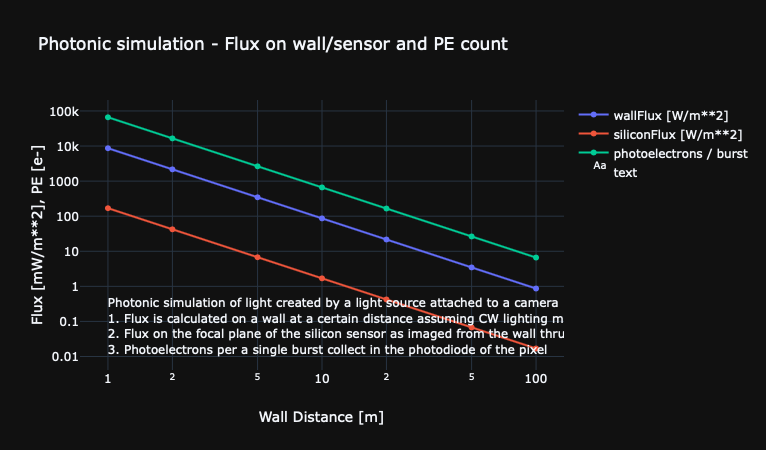

In [4]:
import numpy as np
from plotly.offline import init_notebook_mode, iplot 
import plotly.graph_objs as go
init_notebook_mode(connected=True)  # for Jupyter Lab notebook

photonic = Photonic(config='Cfg2')

dist_vec = np.array([1,2,5,10,20,50,100])
trace0 = go.Scatter(x=dist_vec,
                    y=1000 * photonic.wallFlux(dist_vec=dist_vec), mode='lines+markers',  # Select 'lines', 'markers' or 'lines+markers'
                    name='wallFlux [W/m**2]')
trace1 = go.Scatter(x=dist_vec,
                    y=1000 * photonic.siliconFlux2(dist_vec=dist_vec), mode='lines+markers',
                    name='siliconFlux [W/m**2]')
trace2 = go.Scatter(x=dist_vec,
                    y=photonic.photoelectron2(dist_vec=dist_vec), mode='lines+markers',
                    name='photoelectrons / burst')
trace3 = go.Scatter(x=[1],
                    y=[0.01], mode='text', textposition='top right',
                    name='text', text=['Photonic simulation of light created by a light source attached to a camera<br>'
                    +'1. Flux is calculated on a wall at a certain distance assuming CW lighting mode<br>'
                    +'2. Flux on the focal plane of the silicon sensor as imaged from the wall thru the lens<br>'
                    +'3. Photoelectrons per a single burst collect in the photodiode of the pixel'])

data = [trace0, trace1, trace2, trace3]

layout = {'title': 'Photonic simulation - Flux on wall/sensor and PE count',
          'xaxis': {'title': 'Wall Distance [m]',
                    'type': 'log'},  # Select 'log' or 'linear'
          'yaxis': {'title': 'Flux [mW/m**2], PE [e-]',
                    'type': 'log'},  # Select 'log' or 'linear'
          'template': 'plotly_dark',
          'barmode': 'group',
          'hovermode': 'x'}

iplot({'data': data, 'layout': layout})